In [2]:
#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3 

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
#import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


In [4]:
#raw_df = pd.read_csv("C:\\Users\\mcinn\\Documents\\timeseries_vqa.csv")
raw_df = pd.read_csv(
   "timeseries_vqa.csv",      # relative python path to subdirectory
    usecols=[ "AWC Fiscal Year Month Abbr",	"Brand","Varietal Group", 
    "9L Cases","Avg Sales Price","Sales Dollars"],  # Only load the columns specified.
   )

raw_df.head()
#raw_df.info()

,AWC Fiscal Year Month Abbr,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,F2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17,$28.74,"5,912"
1,F2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1,$28.74,368
2,F2017 FEB,BLACK SAGE VINEYARD,MERLOT,11,$28.74,"3,698"
3,F2017 FEB,BLACK SAGE VINEYARD,OTHER,2,$29.89,909
4,F2017 FEB,CULMINA,CHARDONNAY,0,$41.50,85


In [5]:
# replace Sales Dollar , 9L Cases to NUMBERS format

raw_df['Sales Dollars'] = raw_df['Sales Dollars'].str.replace(',', '').astype(float)
raw_df['9L Cases'] = raw_df['9L Cases'].str.replace(',', '').astype(float)
raw_df['Avg Sales Price'] = raw_df['Avg Sales Price'].str.replace('$', '').astype(float)
raw_df.head()




,AWC Fiscal Year Month Abbr,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,F2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,F2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,F2017 FEB,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,F2017 FEB,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,F2017 FEB,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3671 entries, 0 to 3670
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AWC Fiscal Year Month Abbr  3671 non-null   object 
 1   Brand                       3671 non-null   object 
 2   Varietal Group              3671 non-null   object 
 3   9L Cases                    3671 non-null   float64
 4   Avg Sales Price             3217 non-null   float64
 5   Sales Dollars               3671 non-null   float64
dtypes: float64(3), object(3)
memory usage: 172.2+ KB


In [7]:
raw_df = raw_df.rename({'AWC Fiscal Year Month Abbr': 'Date'}, axis=1) 
raw_df['Date'] = raw_df['Date'].str[1:]
raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,2017 FEB,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,2017 FEB,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,2017 FEB,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [13]:
import datetime
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017-02-01,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,2017-02-01,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,2017-02-01,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,2017-02-01,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,2017-02-01,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [9]:
#import datetime
#raw_df['Date'] = pd.to_datetime(raw_df['Date'], errors='coerce')
#raw_df['Date'] = raw_df['Date'].dt.strftime('%D')
#raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,02/01/17,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,02/01/17,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,02/01/17,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,02/01/17,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,02/01/17,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [15]:
raw_df['Date'].min(), raw_df['Date'].max()


(Timestamp('2017-02-01 00:00:00'), Timestamp('2021-10-01 00:00:00'))

In [16]:
raw_df['Varietal Group'].unique()

array(['CABERNET FRANC', 'CABERNET SAUVIGNON', 'MERLOT', 'OTHER',
       'CHARDONNAY', 'RED BLEND', 'RIESLING', 'VIDAL', 'PINOT NOIR',
       'CHENIN BLANC', 'PINOT BLANC', 'PINOT GRIGIO', 'SHIRAZ',
       'ZINFANDEL', 'WHITE BLEND', 'SAUVIGNON BLANC', 'VIOGNIER', 'ROSE',
       'GEWURZTRAMINER', 'TEMPRANILLO', 'MALBEC', 'UNASSIGNED'],
      dtype=object)

In [17]:
cabernet_franc = raw_df.loc[raw_df['Varietal Group'] == 'CABERNET FRANC']
cabernet_sav = raw_df.loc[raw_df['Varietal Group'] == 'CABERNET SAUVIGNON']
merlot = raw_df.loc[raw_df['Varietal Group'] == 'MERLOT']
chardonnay = raw_df.loc[raw_df['Varietal Group'] == 'CHARDONNAY']
red_blend = raw_df.loc[raw_df['Varietal Group'] == 'RED BLEND']
riesling = raw_df.loc[raw_df['Varietal Group'] == 'RIESLING']
vidal = raw_df.loc[raw_df['Varietal Group'] == 'VIDAL']
pinot_noir = raw_df.loc[raw_df['Varietal Group'] == 'PINOT NOIR']
chenin_blanc = raw_df.loc[raw_df['Varietal Group'] == 'CHENIN BLANC']
pinot_blanc = raw_df.loc[raw_df['Varietal Group'] == 'PINOT BLANC']
pinot_grigio = raw_df.loc[raw_df['Varietal Group'] == 'PINOT GRIGIO']
shiraz = raw_df.loc[raw_df['Varietal Group'] == 'SHIRAZ']
zinfandel = raw_df.loc[raw_df['Varietal Group'] == 'ZINFANDEL']
white_blend = raw_df.loc[raw_df['Varietal Group'] == 'WHITE BLEND']
sav_blanc = raw_df.loc[raw_df['Varietal Group'] == 'SAUVIGNON BLANC']
viognier = raw_df.loc[raw_df['Varietal Group'] == 'VIOGNIER']
rose = raw_df.loc[raw_df['Varietal Group'] == 'ROSE']
gewurz = raw_df.loc[raw_df['Varietal Group'] == 'GEWURZTRAMINER']
tempranillo = raw_df.loc[raw_df['Varietal Group'] == 'TEMPRANILLO']
malbec = raw_df.loc[raw_df['Varietal Group'] == 'MALBEC']
unassigned = raw_df.loc[raw_df['Varietal Group'] == 'UNASSIGNED']
other = raw_df.loc[raw_df['Varietal Group'] == 'OTHER']

## 1) Try Cab Franc 

In [18]:
cabernet_franc.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017-02-01,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
8,2017-02-01,INNISKILLIN ICEWINE,CABERNET FRANC,3.0,69.99,5663.0
12,2017-02-01,INNISKILLIN NIAGARA,CABERNET FRANC,2.0,17.24,465.0
25,2017-02-01,JACKSON TRIGGS NIAGARA,CABERNET FRANC,0.0,44.72,368.0
77,2018-03-01,BLACK SAGE VINEYARD,CABERNET FRANC,99.0,28.74,34285.0


In [19]:
varietal = cabernet_franc
#cols = ['BC Sales Channel',	'AWC and Comp',  'AWC FYr & Pd No',	'Avg Sales Price']
#varietal.drop(cols, axis=1, inplace=True)
varietal = varietal.sort_values('Date')
varietal.isnull().sum()

Date                0
Brand               0
Varietal Group      0
9L Cases            0
Avg Sales Price    32
Sales Dollars       0
dtype: int64

In [20]:
varietal.head()


,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017-02-01,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
8,2017-02-01,INNISKILLIN ICEWINE,CABERNET FRANC,3.0,69.99,5663.0
12,2017-02-01,INNISKILLIN NIAGARA,CABERNET FRANC,2.0,17.24,465.0
25,2017-02-01,JACKSON TRIGGS NIAGARA,CABERNET FRANC,0.0,44.72,368.0
884,2018-01-01,INNISKILLIN ICEWINE,CABERNET FRANC,11.0,66.92,18068.0


## Date is sorted properly ## 

In [21]:
varietal_qty= varietal.groupby(['Date'])['9L Cases'].sum().reset_index()
varietal_qty = varietal_qty.sort_values(by="Date",ascending=True)
varietal_qty.head()


,Date,9L Cases
0,2017-02-01,22.0
1,2018-01-01,95.0
2,2018-02-01,127.0
3,2018-03-01,123.0
4,2018-04-01,116.0


In [22]:
varietal_qty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      45 non-null     datetime64[ns]
 1   9L Cases  45 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [24]:
varietal_qty = varietal_qty.set_index('Date')
varietal_qty.index
varietal_qty.index

DatetimeIndex(['2017-02-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [25]:
varietal_qty.head()

,9L Cases
Date,
2017-02-01,22.0
2018-01-01,95.0
2018-02-01,127.0
2018-03-01,123.0
2018-04-01,116.0


In [26]:
y=varietal_qty
y.head(5)

,9L Cases
Date,
2017-02-01,22.0
2018-01-01,95.0
2018-02-01,127.0
2018-03-01,123.0
2018-04-01,116.0


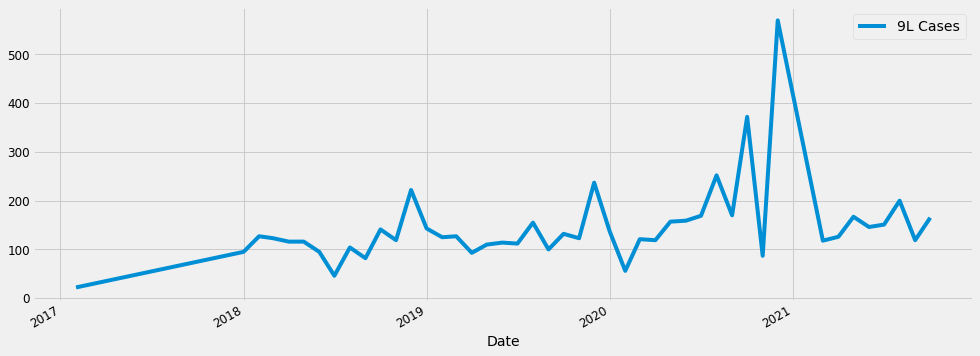

In [27]:
y.plot(figsize=(15, 6))
plt.show()

In [28]:
#varietal_qty_df=pd.DataFrame(data=varietal_qty)
#varietal_qty_df.head()

In [29]:
#varietal_qty.dtypes()

In [30]:
#y = varietal_qty_df['9L Cases'].resample('MS').mean()


In [31]:
df = varietal_qty.rename(columns={'Date': 'ds',
                        '9L Cases': 'y'})

df.head(5)

,y
Date,
2017-02-01,22.0
2018-01-01,95.0
2018-02-01,127.0
2018-03-01,123.0
2018-04-01,116.0


In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = df.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'seasonal_decompose'

# Facebook prophet...install error 

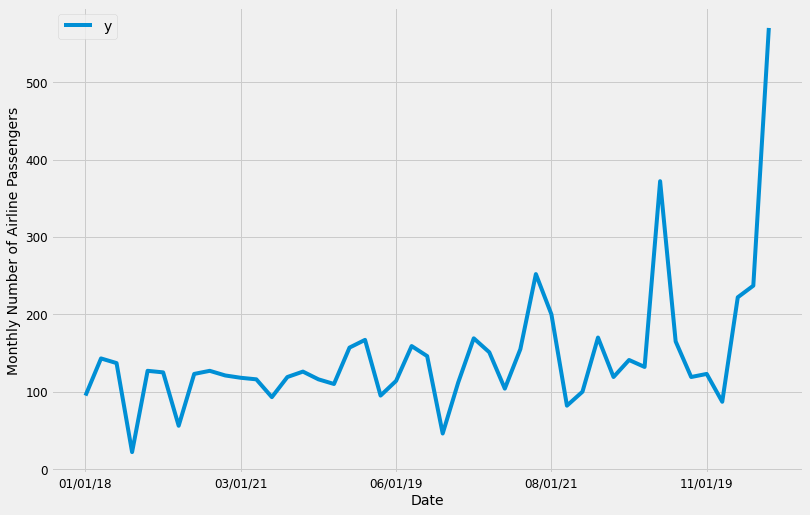

In [312]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

In [323]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [314]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

NameError: name 'Prophet' is not defined